In [9]:
import os
import numpy as np
from scipy import misc
import glob
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.ndimage
import cv2
import scipy.misc

In [10]:
path = './bmpfile/'

dir_path = os.path.join(os.getcwd(), path)  # 현재위치 주소를 가져온다 절대경로로

image_paths = glob.glob(os.path.join(dir_path, '*.bmp')) 

In [4]:
I= 33
L= 21
stride = 21
scale =3

In [13]:
import imageio

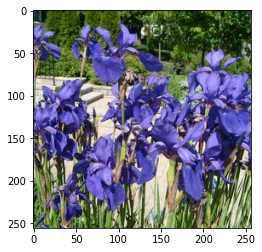

(256, 256, 3)


In [14]:
image =imageio.imread(image_paths[0]).astype(np.int)

plt.imshow(image)
plt.show()
print(image.shape)

In [17]:
inputs = []
labels = []

In [21]:
for path in image_paths:
    image =imageio.imread(path).astype(np.int)
    h,w,c=image.shape
    h = h - np.mod(h,3)
    w = w - np.mod(w,3)
    image = image[:h, :w]
    label = image/255.0
    inp=cv2.GaussianBlur(label,(15,15),0)

    sub_inputs = []
    sub_labels = []

    h, w = inp.shape[0], inp.shape[1]

    offset = abs(I - L)//2

    for hh in range(0, h-I+1, stride):
        for ww in range(0, w-I+1, stride):
            sub_input = inp[hh:hh+I, ww:ww+I]
            sub_label = label[hh+offset:hh+offset+L, ww+offset:ww+offset+L]
            sub_input = sub_input.reshape(I, I, 3)
            sub_label = sub_label.reshape(L, L, 3)
            
            sub_inputs.append(sub_input)
            sub_labels.append(sub_label)
    inputs += sub_inputs
    labels += sub_labels
inputs = np.asarray(inputs) # shape (N, I, I, 1)
labels = np.asarray(labels) # shape (N, L, L, 1)  

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

In [23]:
class SRdataset(Dataset):
    def __init__(self):
        self.inputs,self.labels = inputs,labels
        
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self,idx):
        input_sample = self.inputs[idx]
        label_sample = self.labels[idx]
        input_sample = input_sample.transpose(2,0,1)
        label_sample = label_sample.transpose(2,0,1)
        input_sample, label_sample = torch.Tensor(input_sample), torch.Tensor(label_sample)
        return input_sample,label_sample

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [25]:
class SRCNN(nn.Module):

    def __init__(self):
        super(SRCNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,32,kernel_size=1),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,3,kernel_size=5),
        )
    def forward(self,x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [26]:
model = SRCNN()
model

SRCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
  )
)

In [27]:
crition = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=1e-2,momentum=(0.9))
train_set = SRdataset()
train_loader = DataLoader(train_set,batch_size=64,shuffle=False)

In [29]:
for epoch in range(100):
    for i in train_loader:
        model.zero_grad()
        x, y = i
        image_data = Variable(x)
        label_data = Variable(y)
        output_data = model(image_data)
        loss = crition(output_data,label_data)
        loss.backward()
        optimizer.step()
    print(epoch,loss.mean())
    torch.save(model,'rgb_model/SRCNN_model%s_%s.pkl'%(epoch+100,float(loss.mean())))

0 tensor(0.0015, grad_fn=<MeanBackward0>)
1 tensor(0.0017, grad_fn=<MeanBackward0>)
2 tensor(0.0016, grad_fn=<MeanBackward0>)
3 tensor(0.0014, grad_fn=<MeanBackward0>)
4 tensor(0.0013, grad_fn=<MeanBackward0>)
5 tensor(0.0012, grad_fn=<MeanBackward0>)
6 tensor(0.0012, grad_fn=<MeanBackward0>)
7 tensor(0.0012, grad_fn=<MeanBackward0>)
8 tensor(0.0011, grad_fn=<MeanBackward0>)
9 tensor(0.0011, grad_fn=<MeanBackward0>)
10 tensor(0.0011, grad_fn=<MeanBackward0>)
11 tensor(0.0010, grad_fn=<MeanBackward0>)
12 tensor(0.0010, grad_fn=<MeanBackward0>)
13 tensor(0.0010, grad_fn=<MeanBackward0>)
14 tensor(0.0010, grad_fn=<MeanBackward0>)
15 tensor(0.0010, grad_fn=<MeanBackward0>)
16 tensor(0.0010, grad_fn=<MeanBackward0>)
17 tensor(0.0009, grad_fn=<MeanBackward0>)
18 tensor(0.0010, grad_fn=<MeanBackward0>)
19 tensor(0.0010, grad_fn=<MeanBackward0>)
20 tensor(0.0010, grad_fn=<MeanBackward0>)
21 tensor(0.0010, grad_fn=<MeanBackward0>)
22 tensor(0.0010, grad_fn=<MeanBackward0>)
23 tensor(0.0010, gra

In [128]:
image = cv2.imread('texture.jpg',0)

In [129]:
image.shape

(512, 512)

510 510
torch.Size([1, 3, 158, 498])


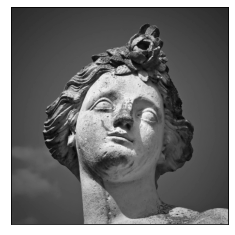

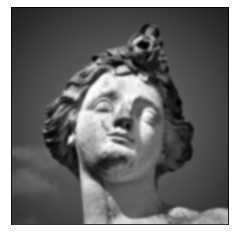

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


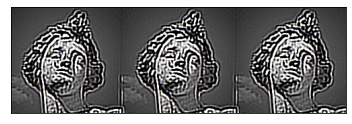

In [126]:
image = cv2.imread('texture.jpg',0)
image = np.reshape(image,(512, 512))
image.shape
inputs = []

labels = []

h,w=(512, 512)

h = h - np.mod(h,3)

w = w - np.mod(w,3)

image = image[:h, :w]

label = image/255.0

inp=cv2.GaussianBlur(label,(15,15),0)
h, w=(510, 510)
print(h,w) 

test_input = inp.reshape(1, 170, w, 3) 

test_input = test_input.transpose(0, 3, 1, 2)

test_input = torch.Tensor(test_input)

test_input = Variable(test_input)

test_output = model(test_input)

print(test_output.shape)

test_output = test_output.data.numpy()

test_output = test_output[0].transpose(1, 2, 0)

h, w = test_output.shape[0], test_output.shape[1]

test_output = test_output.reshape(h, w,3)


plt.imshow(label, cmap='gray')

plt.xticks([]),plt.yticks([])

plt.savefig('label.jpg')

plt.pause(0.005)


plt.imshow(inp, cmap='gray')

plt.xticks([]),plt.yticks([])

plt.savefig('inp.jpg')

plt.pause(0.005)


plt.imshow(test_output, cmap='gray')

plt.xticks([]),plt.yticks([])

plt.savefig('output.jpg')